___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://sp-ao.shortpixel.ai/client/q_glossy,ret_img,w_1024/http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1024x308.png" width="600px" height="100px" />


# <font color= #8A0829> Recurrent Neural Network (RNN).</font>

<Strong> Objetivos </Strong>
- Desarrollar modelos LSTM para la predicción de series temporales univariantes.
- Desarrollar modelos LSTM para la predicción de series temporales multivariables.
- Desarrollar modelos LSTM para la previsión de series temporales en varios pasos.
> Referencias:
    > - http://dprogrammer.org/rnn-lstm-gru
    > - http://introtodeeplearning.com/2019/materials/2019_6S191_L2.pdf
    > - https://www.kaggle.com/code/iamleonie/time-series-tips-tricks-for-training-lstms/notebook
    > - Capítulo 9 de [Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)
___

# 1. Modelos RNN univariados

Demostraremos una serie de variaciones del modelo LSTM para la predicción de series temporales univariantes. Esta sección se divide en seis partes:
1. Preparación de datos 
2. Vanilla LSTM.
3. Stacked LSTM.
4. Bidirectional LSTM.
5. CNN-LSTM.
6. ConvLSTM.

Todos estos modelos serán demostrados para realizar predicciones un paso al futuro.

## 1.1 Preparación de datos
Antes de modelar una serie univariante, hay que prepararla. El modelo CNN aprenderá una función que mapea una secuencia de observaciones pasadas como entrada a una observación de salida. Para ello, la secuencia de observaciones debe transformarse en múltiples ejemplos a partir de los cuales el modelo pueda aprender. Consideremos una secuencia univariante dada:
```
[10, 20, 30, 40, 50, 60, 70, 80, 90]
```
Podemos dividir la secuencia en múltiples patrones de entrada/salida llamados muestras, donde tres pasos temporales se usan como entrada y un paso temporal se usa como salida para la predicción de un paso que se está aprendiendo.
```
X,           y
10, 20, 30, 40
20, 30, 40, 50
30, 40, 50, 60
...
```
Para realizar este procedimiento vamos a utilizar la función que desarrollamos en clases pasadas:

In [6]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import plot_model

In [2]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# Definir la secuencia de entrada
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# Elegir un número de pasos de tiempo
n_steps = 3
# Número de características de mis datos
n_features = 1
# Dividir en muestras
X, y = split_univariate_sequence(raw_seq, n_steps)

print('X', X, 'y', y, sep='\n')

X
[[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]]
y
[40 50 60 70 80 90]


## 1.2 Vanilla LSTM

Un Vanilla LSTM es un modelo LSTM que **tiene una sola capa oculta de unidades LSTM y una capa de salida que se utiliza para hacer una predicción**. La clave de las LSTM es que ofrecen soporte nativo para secuencias. A diferencia de una CNN, que lee todo el vector de entrada, el modelo LSTM lee un paso temporal de la secuencia cada vez y construye una representación de estado interna que puede utilizarse como contexto aprendido para realizar una predicción. Podemos definir un LSTM de vainilla para la predicción de series temporales univariantes de la siguiente manera.

*La documentación de Keras recomienda el optimizador RMSprop para RNNs*


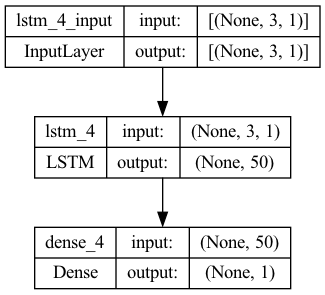

In [29]:
model_1 = Sequential()
model_1.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(Dense(1))
model_1.compile(optimizer='RMSprop', loss='mse')

plot_model(model_1, show_shapes=True)

Antes de entrenar nuestro modelo debemos redimensionar nuestros datos de entrada

In [25]:
# reshape de [samples, timesteps] a [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

Ahora vamos a especificar los criterios de parada anticipada (Regularización). La parada temprana (Early Stopping) es un método de regularización utilizado para evitar el sobreajuste al entrenar un modelo de aprendizaje con un método iterativo, como el descenso de gradiente. Cuando el overffitting empieza, el entrenamiento es detenido para evitar este sobreajuste. Debemos definir lo que la métrica que deseamos monitorear. Si dicha métrica no mejora por `min_delta` después de `patient` epochs, el entrenamiento se detendrá.

In [30]:
from keras.callbacks import EarlyStopping

LSTM_earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=5)

Con estos datos estamos listo para entrenar nuestro modelo.

In [31]:
# Ajustamos el modelo anterior
history_1 = model_1.fit(
    X, 
    y, 
    epochs=400, 
    callbacks=[LSTM_earlystop],
    verbose=1
)

Epoch 1/400
1/1 [==============================] - 1s 710ms/step - loss: 4818.6509
Epoch 2/400
1/1 [==============================] - 0s 5ms/step - loss: 4642.3242
Epoch 3/400
1/1 [==============================] - 0s 5ms/step - loss: 4490.1235
Epoch 4/400
1/1 [==============================] - 0s 4ms/step - loss: 4335.8960
Epoch 5/400
1/1 [==============================] - 0s 4ms/step - loss: 4168.6211
Epoch 6/400
1/1 [==============================] - 0s 5ms/step - loss: 3981.7097
Epoch 7/400
1/1 [==============================] - 0s 4ms/step - loss: 3775.7188
Epoch 8/400
1/1 [==============================] - 0s 3ms/step - loss: 3558.2881
Epoch 9/400
1/1 [==============================] - 0s 4ms/step - loss: 3336.7532
Epoch 10/400
1/1 [==============================] - 0s 4ms/step - loss: 3110.0242
Epoch 11/400
1/1 [==============================] - 0s 3ms/step - loss: 2867.5710
Epoch 12/400
1/1 [==============================] - 0s 3ms/step - loss: 2593.0745
Epoch 13/400
1/1 [=====

1/1 [==============================] - 0s 3ms/step - loss: 6.1882
Epoch 104/400
1/1 [==============================] - 0s 4ms/step - loss: 5.6149
Epoch 105/400
1/1 [==============================] - 0s 3ms/step - loss: 5.7373
Epoch 106/400
1/1 [==============================] - 0s 3ms/step - loss: 5.2139
Epoch 107/400
1/1 [==============================] - 0s 4ms/step - loss: 5.3374
Epoch 108/400
1/1 [==============================] - 0s 4ms/step - loss: 4.8981
Epoch 109/400
1/1 [==============================] - 0s 3ms/step - loss: 5.0615
Epoch 110/400
1/1 [==============================] - 0s 3ms/step - loss: 4.6889
Epoch 111/400
1/1 [==============================] - 0s 3ms/step - loss: 4.9013
Epoch 112/400
1/1 [==============================] - 0s 3ms/step - loss: 4.5520
Epoch 113/400
1/1 [==============================] - 0s 3ms/step - loss: 4.7924
Epoch 114/400
1/1 [==============================] - 0s 3ms/step - loss: 4.4218
Epoch 115/400
1/1 [==============================] - 0

1/1 [==============================] - 0s 4ms/step - loss: 2.0321
Epoch 206/400
1/1 [==============================] - 0s 4ms/step - loss: 1.8185
Epoch 207/400
1/1 [==============================] - 0s 3ms/step - loss: 2.0198
Epoch 208/400
1/1 [==============================] - 0s 4ms/step - loss: 1.8072
Epoch 209/400
1/1 [==============================] - 0s 4ms/step - loss: 2.0078
Epoch 210/400
1/1 [==============================] - 0s 3ms/step - loss: 1.7958
Epoch 211/400
1/1 [==============================] - 0s 4ms/step - loss: 1.9956
Epoch 212/400
1/1 [==============================] - 0s 4ms/step - loss: 1.7844
Epoch 213/400
1/1 [==============================] - 0s 4ms/step - loss: 1.9834
Epoch 214/400
1/1 [==============================] - 0s 4ms/step - loss: 1.7731
Epoch 215/400
1/1 [==============================] - 0s 4ms/step - loss: 1.9716
Epoch 216/400
1/1 [==============================] - 0s 4ms/step - loss: 1.7624
Epoch 217/400
1/1 [==============================] - 0

1/1 [==============================] - 0s 4ms/step - loss: 1.6441
Epoch 308/400
1/1 [==============================] - 0s 4ms/step - loss: 1.4724
Epoch 309/400
1/1 [==============================] - 0s 4ms/step - loss: 1.6495
Epoch 310/400
1/1 [==============================] - 0s 4ms/step - loss: 1.4710
Epoch 311/400
1/1 [==============================] - 0s 4ms/step - loss: 1.6359
Epoch 312/400
1/1 [==============================] - 0s 4ms/step - loss: 1.4652
Epoch 313/400
1/1 [==============================] - 0s 4ms/step - loss: 1.6413
Epoch 314/400
1/1 [==============================] - 0s 4ms/step - loss: 1.4636
Epoch 315/400
1/1 [==============================] - 0s 5ms/step - loss: 1.6266
Epoch 316/400
1/1 [==============================] - 0s 4ms/step - loss: 1.4579
Epoch 317/400
1/1 [==============================] - 0s 4ms/step - loss: 1.6343
Epoch 318/400
1/1 [==============================] - 0s 4ms/step - loss: 1.4569
Epoch 319/400
1/1 [==============================] - 0

<AxesSubplot: >

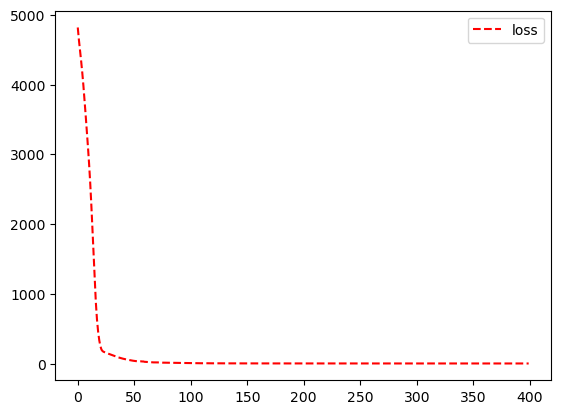

In [32]:
pd.DataFrame(history_1.history).plot(style='r--')

In [33]:
# Probamos nuestro modelo 
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_1.predict(x_input, verbose=0)
yhat

array([[99.92972]], dtype=float32)

## 1.2 Stacked LSTM

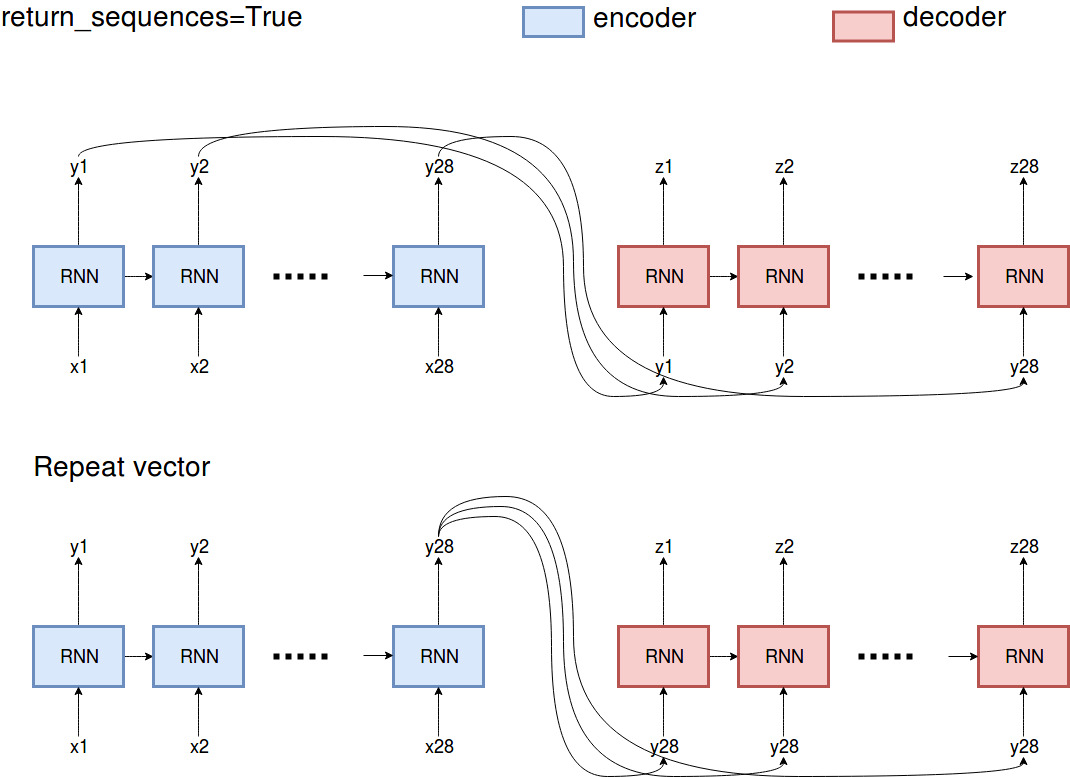

> Referencia: https://stackoverflow.com/a/51757012

Se pueden apilar varias capas LSTM ocultas, una sobre otra, en lo que se denomina un modelo LSTM apilado. Una capa LSTM requiere una entrada tridimensional y las LSTM producen por defecto una salida bidimensional como interpretación del final de la secuencia. Podemos solucionar esto haciendo que el **LSTM produzca un valor para cada paso de tiempo en los datos de entrada** estableciendo el argumento `return_sequences=True` en la capa. Esto nos permite tener la salida 3D de la capa LSTM oculta como entrada para la siguiente. Por lo tanto, podemos definir un LSTM apilado de la siguiente manera.

In [62]:
model_2 = Sequential()
model_2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_2.add(LSTM(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='RMSprop', loss='mse')

model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 3, 50)             10400     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Ajustamos el modelo anterior
history_2 = model_2.fit(
    X, 
    y, 
    epochs=200, 
    callbacks=[LSTM_earlystop],
    verbose=0
)

<AxesSubplot: >

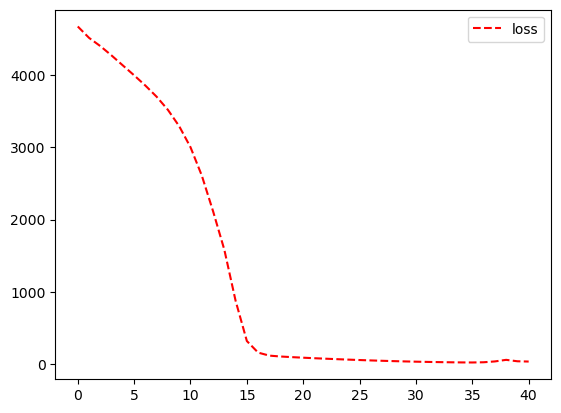

In [64]:
pd.DataFrame(history_2.history).plot(style='r--')

In [65]:
# Probamos nuestro modelo 
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_2.predict(x_input, verbose=0)
yhat

array([[104.41319]], dtype=float32)

## 1.3 Bidirectional LSTM

En algunos problemas de predicción de secuencias, puede ser **beneficioso permitir que el modelo LSTM aprenda la secuencia de entrada tanto hacia delante como hacia atrás y concatene ambas interpretaciones**. Esto se denomina LSTM bidireccional. Podemos implementar un LSTM Bidireccional para predicción de series temporales univariantes envolviendo la primera capa oculta en una capa envolvente llamada Bidireccional.  Un ejemplo de definir un LSTM Bidireccional para leer la entrada tanto hacia adelante como hacia atrás es el siguiente.

In [80]:
from keras.layers import Bidirectional

model_3 = Sequential()
model_3.add(Bidirectional(
    LSTM(50, activation='relu'),
    input_shape=(n_steps, n_features)
))
model_3.add(Dense(1))
model_3.compile(optimizer='RMSprop', loss='mse')

model_3.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [81]:
# Ajustamos el modelo anterior
history_3 = model_3.fit(
    X, 
    y, 
    epochs=200, 
#     callbacks=[LSTM_earlystop],
    verbose=0
)

<AxesSubplot: >

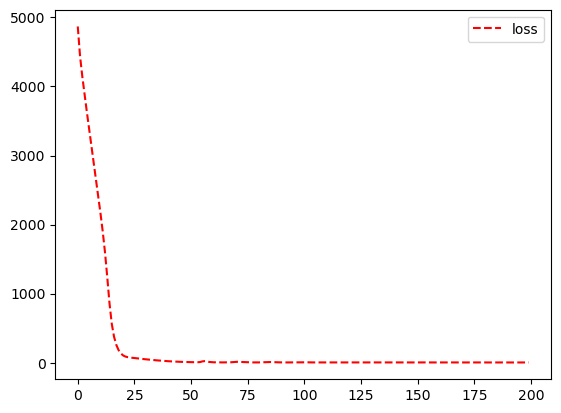

In [82]:
pd.DataFrame(history_3.history).plot(style='r--')

In [77]:
# Probamos nuestro modelo 
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_3.predict(x_input, verbose=0)
yhat

array([[104.682846]], dtype=float32)

In [67]:
from keras.layers import Bidirectional

model_3 = Sequential()
model_3.add(Bidirectional(
    LSTM(50, activation='relu'),
    input_shape=(n_steps, n_features)
))
model_3.add(Dense(1))
model_3.compile(optimizer='RMSprop', loss='mse')

model_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


## 1.4 CNN-LSTM

Estructura de la red

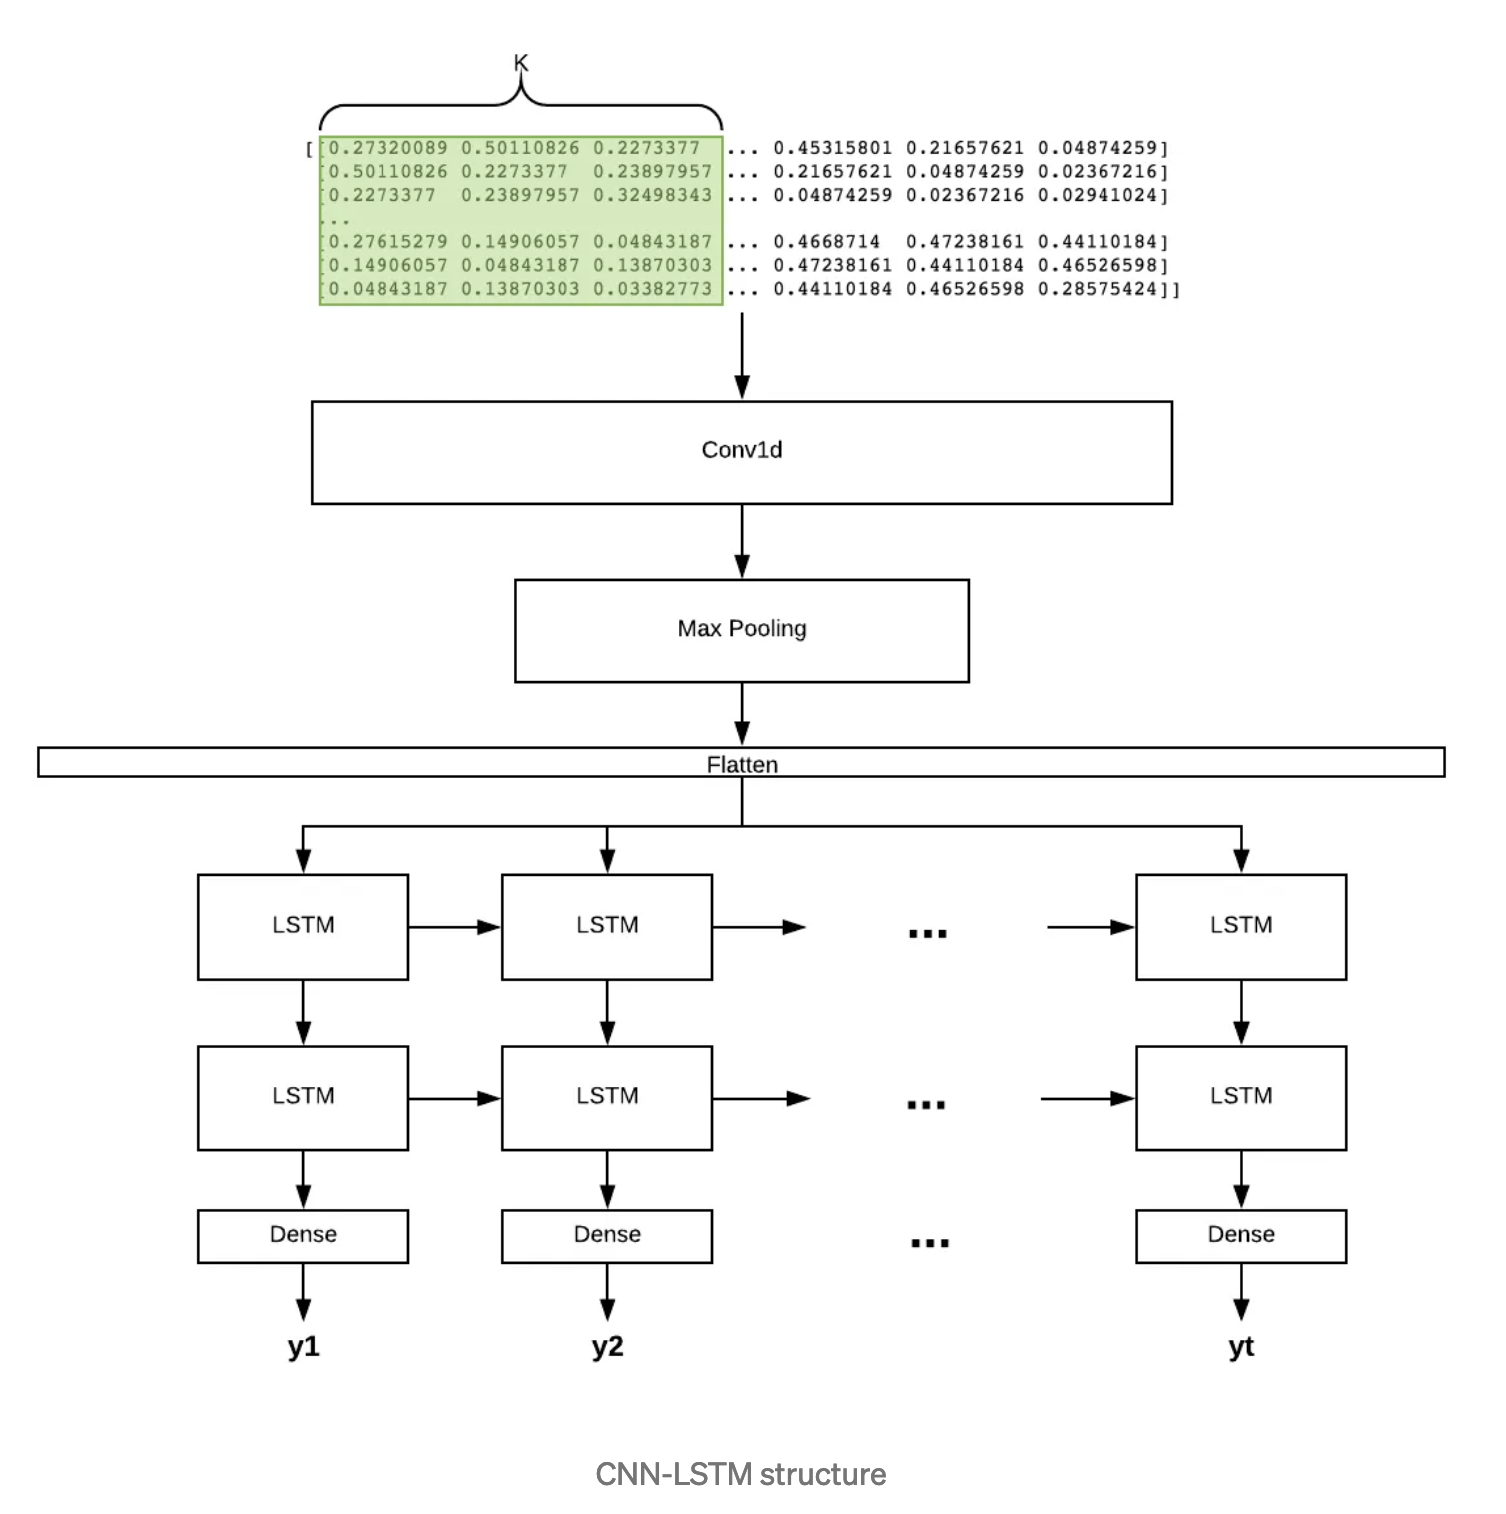
> Referencia: https://towardsdatascience.com/get-started-with-using-cnn-lstm-for-forecasting-6f0f4dde5826

RNN son capaces de varios tipos diferentes de combinaciones de entrada/salida, como se ve a continuación

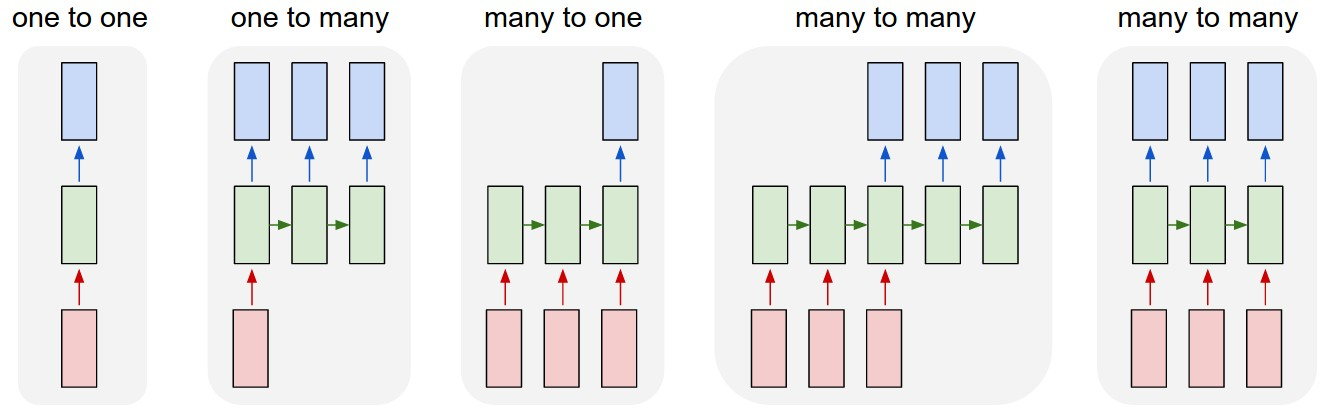
> Referencia: https://github.com/keras-team/keras/issues/1029#issuecomment-158105579

La  <font color= red> red CNN puede ser muy eficaz para extraer y aprender automáticamente características a partir de datos de secuencias unidimensionales </font>. Un modelo CNN puede utilizarse en un modelo híbrido con un backend LSTM en el que la **CNN se utiliza para interpretar subsecuencias de entrada** que, juntas, se proporcionan como secuencia a un modelo LSTM para su interpretación. Este modelo híbrido se denomina `CNN-LSTM`.

1. Dividimos las secuencias de entrada en secuencias que puedan ser procesadas por el modelo CNN. Por ejemplo, podemos dividir primero nuestros datos de series temporales univariantes en muestras de entrada/salida con cuatro pasos como entrada y uno como salida. 
2. Cada muestra puede dividirse en dos submuestras, cada una con dos pasos temporales. La CNN puede interpretar cada subsecuencia de dos pasos temporales y proporcionar una serie temporal de interpretaciones de las subsecuencias al modelo LSTM para que las procese como entrada. Podemos parametrizar esto y definir el número de subsecuencias como `n_seq` y el número de pasos temporales por subsecuencia como `n_step`. Los datos de entrada pueden entonces reformarse para que tengan la estructura requerida: `[muestras, subsecuencias, pasos temporales, características]`.
 Por ejemplo:

In [85]:
# Elegir un número de pasos de tiempo
n_steps = 4
# Dividir en muestras
X, y = split_univariate_sequence(raw_seq, n_steps)
print(f'Shape función split {X.shape}')
# reshape de [samples, timesteps] a [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
print(f'Shape después de la transformación  {X.shape}')

Shape función split (5, 4)
Shape después de la transformación  (5, 2, 2, 1)


In [88]:
X[0].shape

(2, 2, 1)

Queremos reutilizar el mismo modelo CNN al leer cada subsecuencia de datos por separado. Esto se puede conseguir envolviendo todo el modelo CNN en un contenedor `TimeDistributed` que aplicará todo el modelo una vez por entrada, en este caso, una vez por subsecuencia de entrada. El modelo CNN tiene primero una capa convolucional para leer a través de la subsecuencia que requiere que se especifique un número de filtros y un tamaño de kernel. <font color= blue>El número de filtros es el número de lecturas o interpretaciones de la secuencia de entrada </font>. <font color= red> El tamaño del kernel es el número de pasos temporales </font> incluidos en cada operación de lectura de la secuencia de entrada.

En resumen, la capa **TimeDistributed** es una especie de contenedor y espera otra capa como argumento. Aplica esta capa a cada porción temporal de entrada y, por lo tanto, permite construir modelos que tienen arquitecturas de *one-to-many*, *many-to-many*. Del mismo modo, espera la entrada al menos con 3 dimensiones.

In [89]:
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_29 (LSTM)              (None, 50)                23000     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                     

<AxesSubplot: >

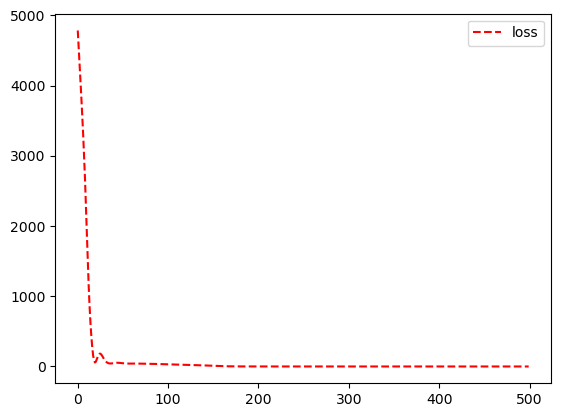

In [93]:
# Definimos nuestro modelo
model_4 = Sequential()
model_4.add(TimeDistributed(Conv1D(64, 1, activation='relu'), input_shape=(None, n_steps, n_features)))
model_4.add(TimeDistributed(MaxPooling1D(pool_size=n_seq)))
model_4.add(TimeDistributed(Flatten()))
model_4.add(LSTM(50, activation='relu'))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mse')
# fit model_4
history_4 = model_4.fit(X, y, epochs=500, verbose=0)
model_4.summary()

# Probamos nuestro modelo 
x_input = np.array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model_4.predict(x_input, verbose=0)
print(yhat)

pd.DataFrame(history_4.history).plot(style='r--')

## 1.5 ConvLSTM

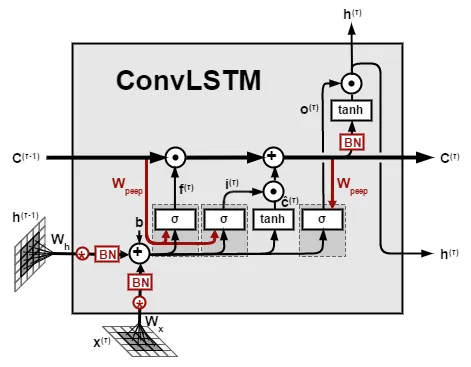
> Referencia: https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7

Un tipo de LSTM relacionado con la CNN-LSTM es la ConvLSTM, en la que la lectura convolucional de la entrada se incorpora directamente en cada unidad LSTM. La ConvLSTM se desarrolló para la lectura de datos espacio-temporales bidimensionales, pero puede adaptarse para su uso con predicciones de series temporales univariantes. La capa espera la entrada como una secuencia de imágenes bidimensionales, por lo que la forma de los datos de entrada debe ser: `[muestras, pasos de tiempo, filas, columnas, características]`.

Para nuestros propósitos, podemos dividir cada muestra en subsecuencias donde los pasos de tiempo serán el número de subsecuencias, o `n_seq`, y las columnas serán el número de pasos de tiempo para cada subsecuencia, o `n_steps`. El número de filas se fija en 1, ya que trabajamos con datos unidimensionales. Ahora podemos remodelar las muestras preparadas en la estructura requerida.

In [94]:
# Elegir un número de pasos de tiempo
n_steps = 4
# Dividir en muestras
X, y = split_univariate_sequence(raw_seq, n_steps)
print(f'Shape función split {X.shape}')
# reshape de [samples, timesteps] a [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
print(f'Shape después de la transformación  {X.shape}')

Shape función split (5, 4)
Shape después de la transformación  (5, 2, 1, 2, 1)


In [ ]:
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [95]:
from keras.layers import ConvLSTM2D 

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 1, 64)          33536     
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________
Predicción: [[103.70958]]


<AxesSubplot: >

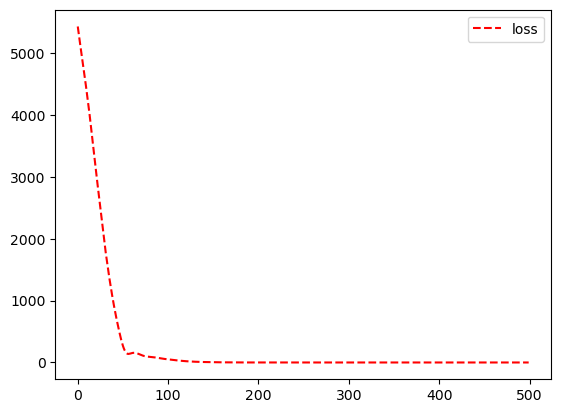

In [100]:
# Definimos nuestro modelo
model_5 = Sequential()

model_5.add(
    ConvLSTM2D(
        filters=64, 
        # kernel_size en términos de (row, columns)
        kernel_size=(1, n_steps), 
        activation='relu', 
        input_shape=(n_seq, 1, n_steps, n_features)
    )
)
model_5.add(Flatten())
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mse')
model_5.summary()

# fit model_5
history_5 = model_5.fit(X, y, epochs=500, verbose=0)


# Probamos nuestro modelo 
x_input = np.array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model_5.predict(x_input, verbose=0)
print('Predicción:', yhat)

pd.DataFrame(history_5.history).plot(style='r--')

# 2. Modelos LSTM multivariados

Por datos de series temporales multivariantes se entienden los datos en los que hay más de una observación para cada cada paso temporal. Hay dos modelos principales que podemos necesitar con datos de series temporales multivariantes; ellos son:
1. Series de entrada múltiples.
2. Múltiples Series Paralelas.

## 2.1 Series de entradas múltiples

Las series temporales de entrada son paralelas porque cada serie tiene observaciones en los mismos pasos temporales

In [101]:
# Definir secuencias de entrada
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
output_seq = in_seq1 + in_seq2

in_seq1.shape, output_seq.shape

((9,), (9,))

In [102]:
# Vamos a poner toda esta información en forma matricial 2D
# Para ello tenemos que definir el shape de cada secuencia
in_seq1 = in_seq1.reshape(in_seq1.shape[0], 1)
in_seq2 = in_seq2.reshape(in_seq2.shape[0], 1)
output_seq = output_seq.reshape(output_seq.shape[0], 1)

in_seq1.shape, output_seq.shape

((9, 1), (9, 1))

In [103]:
# Concatenar horizontalmente nuestra data
dataset = np.hstack([in_seq1, in_seq2, output_seq])
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [104]:
# dividir una secuencia multivariada en muestras
def split_multivariate_sequence(sequence: np.ndarray, n_steps: int):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [105]:
n_steps = 3
X, y = split_multivariate_sequence(dataset, n_steps)

n_features = X.shape[2]

X.shape, y.shape

((7, 3, 2), (7,))

In [109]:
[print(X[i], y[i]) for i in range(len(X))];

[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


### Nota:
Con los datos con la estructura definida, podemos usar cualquiera de las configuraciones que vimos en la sección anterior `Vanilla, Stacked, Bidirectional, CNN, or ConvLSTM`. Para efectos ilustrativos nada más usaremos Vanilla LSTM.

In [111]:
# Definir nuestro model_6
model_6 = Sequential()
model_6.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model_6.add(Dense(1))
model_6.compile(optimizer='adam', loss='mse')
# fit model_6
model_6.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_6.predict(x_input, verbose=0)
print(yhat)

[[206.85837]]


## 2.2 Múltiples series paralelas (multivariable forecasting)

Un problema de series temporales alternativo es el caso en el que hay múltiples series temporales paralelas y se debe realizar una predecicción para cada una de ellas. Por ejemplo, dados los datos de la sección anterior:
```
[[ 10 15 25]
[ 20 25 45]
[ 30 35 65]
[ 40 45 85]
[ 50 55 105]
[ 60 65 125]
[ 70 75 145]
[ 80 85 165]
[ 90 95 185]]
```
Es posible que queramos predecir el valor de cada una de las tres series temporales para el siguiente paso temporal. Esto podría denominarse predicción multivariante. Una vez más, los datos deben dividirse en muestras de entrada/salida para poder entrenar un modelo. La primera muestra de este conjunto de datos sería:

**Entrada**
```
10, 15, 25
20, 25, 45
30, 35, 65
```
**Salida**
```
40, 45, 85
```

Para este comportamiento debemos de modificar un poco la función `split_multivariate_sequence()` de la siguiente forma

In [ ]:
# dividir una secuencia multivariada en muestras para predicción múltiple
def split_multiple_forecasting_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps
        
        # comprobar si estamos más allá de la secuencia
        if end_ix > len(sequence)-1:
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
dataset

In [ ]:
n_steps = 3
X, y = split_multiple_forecasting_sequence(dataset, n_steps=3)

In [ ]:
X, y

Usaremos ahora una `Stacked LSTM` para realizar nuestras predicciones:

In [123]:
# el conjunto de datos conoce la cantidad de características, p. 2
n_features = X.shape[2]

# Definir el model_7
model_7 = Sequential()
model_7.add(LSTM(100, activation='relu', 
                 return_sequences=True, 
                 input_shape=(n_steps, n_features)))
model_7.add(LSTM(100, activation='relu'))
model_7.add(Dense(n_features))
model_7.compile(optimizer='adam', loss='mse')

# fit model_7
model_7.fit(X, y, epochs=400, verbose=0)

# Probar nuestro modelo
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_7.predict(x_input, verbose=0)
print(yhat)

[[100.5488  104.98647 205.68307]]


# 3. Modelos LSTM de pasos múltiples

Un problema de predicción de series temporales que requiere una predicción de varios pasos temporales en el futuro puede denominarse predicción de series temporales de varios pasos. En concreto, se trata de problemas en los que el horizonte o intervalo de predicción es superior a un paso temporal. Hay dos tipos principales de modelos LSTM que pueden utilizarse para la predicción en varios pasos:
1. Vector Output Model
2. Encoder-Decoder Model

## 3.1 Serie temporal univariada
Ejemplo,
```
[10, 20, 30, 40, 50, 60, 70, 80, 90]
```
Pudiéramos usar tres pasos de la entrada para predecir los siguientes dos pasos. Para el ejemplo anterior la primera muestra de la entrada sería

**Entrada**
```
[10, 20, 30]
```
**Salida**
```
[40, 50]
```

In [128]:
# dividir una secuencia univariada en muestras
def split_univariate_sequence_m_step(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # encontrar el final de este patrón
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # comprobar si estamos más allá de la secuencia
        if out_end_ix > len(sequence):
            break
        # reunir partes de entrada y salida del patrón
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [129]:
# Probemos la función creada
# Definir secuencia de entrada
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# elegir un número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2
# Particionar mis datos
X, y = split_univariate_sequence_m_step(raw_seq, n_steps_in, n_steps_out)
# Resumir los datos
[print(X[i], y[i]) for i in range(len(X))];

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [ ]:
X.shape, y.shape

In [130]:
# Debemos tranformar nuestro datos de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(5, 3, 1)

In [132]:
# define model
model = Sequential()
model.add(LSTM(100, 
               activation='relu', 
               return_sequences=True, 
               input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=50, verbose=0)

# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[122.129776 137.98587 ]]


<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>